<a href="https://colab.research.google.com/github/NathanPhilipB/Blindness_Detection_NathanPhilipB/blob/main/Nathan_CodeClause_Blindness_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT DATASET

In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [01:04<00:00, 19.2MB/s]
100% 9.51G/9.51G [01:04<00:00, 160MB/s] 


In [2]:
!unzip /content/aptos2019-blindness-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

In [3]:
!kaggle competitions download -c aptos2019-blindness-detection -f train.csv
!kaggle competitions download -c aptos2019-blindness-detection -f test.csv

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, applications
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import random
import cv2
import shutil
import pandas as pd

from sklearn.model_selection import train_test_split

In [5]:
SEED = 42

#PREPROCESSING FUNCTIONS

##CROPPING

In [6]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance

    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

##CIRCLE-CROP + BEN GRAHAM

In [21]:
def circle_crop(img, sigmaX=10):


    img = cv2.imread(img)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

##CIRCLE-CROP + BEN GRAHAM + IMG RESIZE 244

In [7]:
def circle_crop(img, sigmaX=10):


    img = cv2.imread(img)


    #img = cv2.resize(img, (640, 640))


    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)


    #img = cv2.resize(img, (640, 640))
    img = cv2.resize(img, (224, 224))



    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

##CIRCLE-CROP + BEN GRAHAM + IMG RESIZE 640 / 1024

In [7]:
def circle_crop(img, sigmaX=10):


    img = cv2.imread(img)


    #img = cv2.resize(img, (640, 640))


    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    #img = cv2.resize(img, (640, 640))
    img = cv2.resize(img, (1024, 1024))


    img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

##PREPROCESSING NO_CIRCLE_CROP

In [ ]:
def preprocess(input_folder):
    # List all files in the input folder
    file_list = os.listdir(input_folder)

    for file_name in file_list:
        # Construct the input file path
        input_path = os.path.join(input_folder, file_name)

        # Read the image using cv2
        image = cv2.imread(input_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = crop_image_from_gray(image)
        image = cv2.resize(image, (640, 640))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) ,-4 ,128)

        # Save the grayscale image, overwriting the original image
        cv2.imwrite(input_path, image)

# Specify the input folder
input_folder = '/content/train_images'

# Convert images to grayscale using cv2 and overwrite the originals
preprocess(input_folder)


##PREPROCESSING YES_CIRCLE_CROP

In [8]:
def preprocess_circle_crop(input_folder):
    # List all files in the input folder
    file_list = os.listdir(input_folder)

    for file_name in file_list:
        # Construct the input file path
        input_path = os.path.join(input_folder, file_name)

        image = circle_crop(input_path,sigmaX=10)

        # Save the graysca-le image, overwriting the original image
        cv2.imwrite(input_path, image)

# Specify the input folder
input_folder = '/content/train_images'

# Convert images to grayscale using cv2 and overwrite the originals
preprocess_circle_crop(input_folder)


In [ ]:
def preprocess_circle_crop(input_folder):
    # List all files in the input folder
    file_list = os.listdir(input_folder)

    for file_name in file_list:
        # Construct the input file path
        input_path = os.path.join(input_folder, file_name)

        img = cv2.imread(input_path)
        img = crop_image_from_gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        height, width, depth = img.shape

        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))

        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        img = crop_image_from_gray(img)
        img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX=10) ,-4 ,128)

        # Save the grayscale image, overwriting the original image
        cv2.imwrite(input_path, img)

# Specify the input folder
input_folder = '/content/train_images'

# Convert images to grayscale using cv2 and overwrite the originals
preprocess_circle_crop(input_folder)


KeyboardInterrupt: ignored

#DISPLAYING TESTING

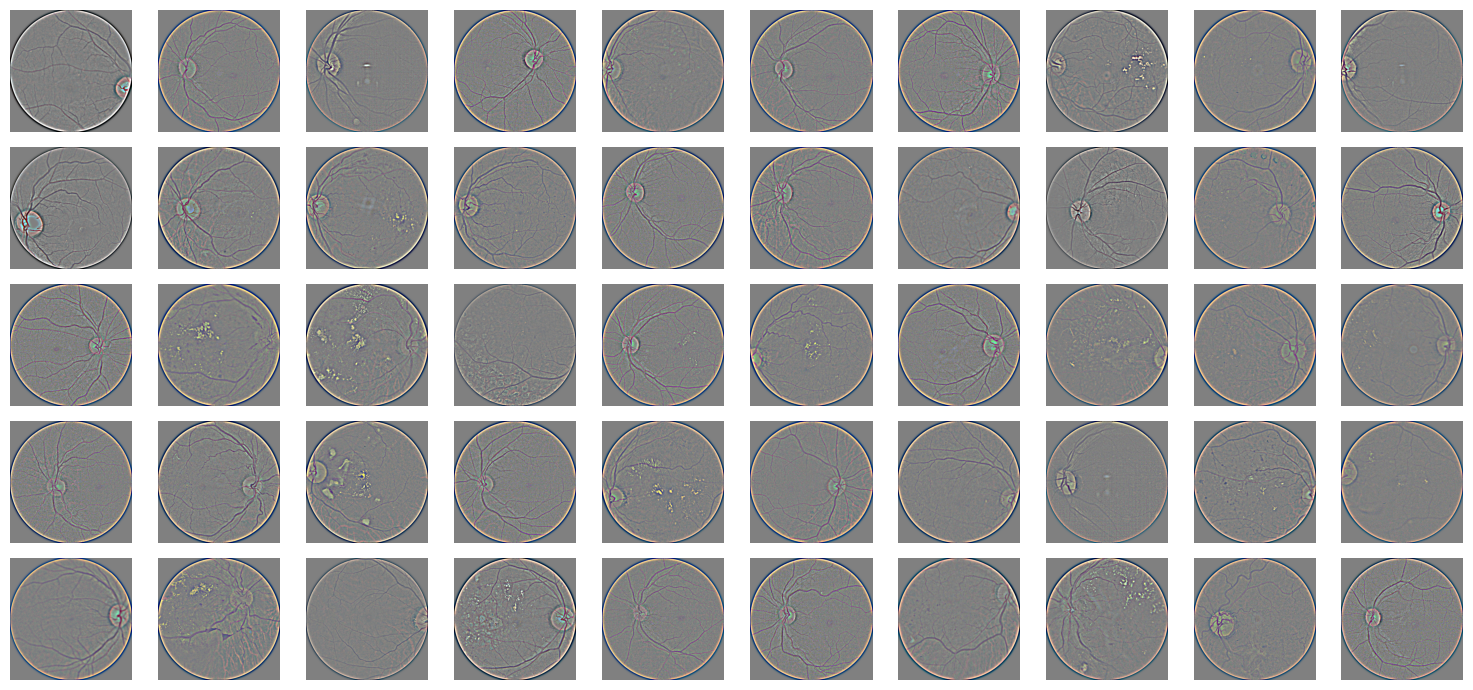

In [11]:
import matplotlib.image as mpimg

def display_random_images(directory_path, num_images=50):

    IMG_SIZE=640
    # Get a list of all files in the directory
    all_files = os.listdir(directory_path)

    # Filter out non-image files (you may need to adjust this based on your file types)
    image_files = [file for file in all_files if file.endswith(('.png', '.jpg', '.jpeg'))]

    # Select num_images random images
    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    # Set up subplots
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(15, 7))

    # Flatten the axes for easy iteration
    axes = axes.flatten()

    # Loop through the selected image names and plot them
    for i, image_name in enumerate(selected_images):
        # Construct the full path to the image
        image_path = os.path.join(directory_path, image_name)

        # Read and display the image

        image = cv2.imread(image_path)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = crop_image_from_gray(image)
        #image = cv2.resize(image, (640, 640))
        #image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=10) ,-4 ,128)

        #image = circle_crop(image_path,sigmaX=10)


        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis labels for better visualization

    plt.tight_layout()
    plt.show()

image_directory = '/content/train_images'
display_random_images(image_directory, num_images=50)

#FORMATTING DATASET DIRECTORY
#(train-val-test)


In [12]:
# Load CSV file
csv_file_path = '/content/train.csv'
df = pd.read_csv(csv_file_path)

X = df['id_code']
y = df['diagnosis']

In [13]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=SEED)

In [14]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# Print the sizes of each set
print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Validation set size: {X_val.shape}, {y_val.shape}")
print(f"Test set size: {X_test.shape}, {y_test.shape}")

Training set size: (2563,), (2563,)
Validation set size: (549,), (549,)
Test set size: (550,), (550,)


In [15]:
X_train = (X_train.reset_index()).drop(['index'], axis=1)
y_train = (y_train.reset_index()).drop(['index'], axis=1)
X_val = (X_test.reset_index()).drop(['index'], axis=1)
y_val = (y_test.reset_index()).drop(['index'], axis=1)
X_test = (X_test.reset_index()).drop(['index'], axis=1)
y_test = (y_test.reset_index()).drop(['index'], axis=1)

In [16]:
X_train.loc[0, 'id_code']

'4ef16a53d899'

In [17]:
# Path to the directory containing images
images_directory = '/content/train_images'

os.makedirs('/content/dataset/train', exist_ok=True)
os.makedirs('/content/dataset/val', exist_ok=True)
os.makedirs('/content/dataset/test', exist_ok=True)

# Create subfolders for each class
for class_label in range(5):
    class_folder = f'/content/dataset/train/{class_label}/'
    os.makedirs(class_folder, exist_ok=True)
for class_label in range(5):
    class_folder = f'/content/dataset/val/{class_label}/'
    os.makedirs(class_folder, exist_ok=True)
for class_label in range(5):
    class_folder = f'/content/dataset/test/{class_label}/'
    os.makedirs(class_folder, exist_ok=True)

# Move images to corresponding subfolders
for n in range(len(X_train)):
    image_filename = X_train.loc[n, 'id_code']
    class_label = y_train.loc[n, 'diagnosis']

    source_path = os.path.join(images_directory, image_filename+'.png')
    destination_folder = f'/content/dataset/train/{class_label}/'
    destination_path = os.path.join(destination_folder, image_filename+'.png')

    shutil.copy(source_path, destination_path)

for n in range(len(X_val)):
    image_filename = X_val.loc[n, 'id_code']
    class_label = y_val.loc[n, 'diagnosis']

    source_path = os.path.join(images_directory, image_filename+'.png')
    destination_folder = f'/content/dataset/val/{class_label}/'
    destination_path = os.path.join(destination_folder, image_filename+'.png')

    shutil.copy(source_path, destination_path)

for n in range(len(X_test)):
    image_filename = X_test.loc[n, 'id_code']
    class_label = y_test.loc[n, 'diagnosis']

    source_path = os.path.join(images_directory, image_filename+'.png')
    destination_folder = f'/content/dataset/test/{class_label}/'
    destination_path = os.path.join(destination_folder, image_filename+'.png')

    shutil.copy(source_path, destination_path)

#CHECKING BALANCE

In [ ]:
train_counts = y_train['diagnosis'].value_counts()
val_counts = y_val['diagnosis'].value_counts()
test_counts = y_test['diagnosis'].value_counts()

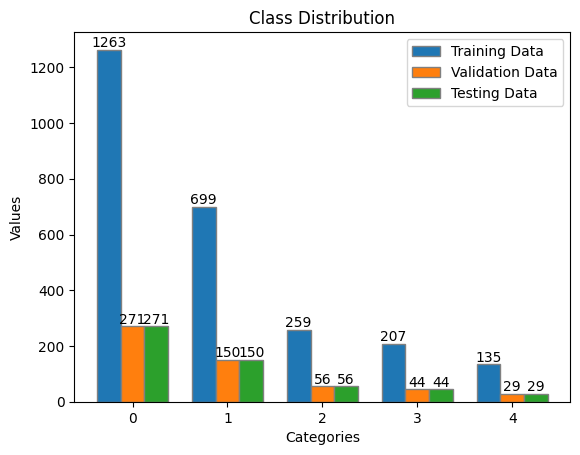

In [ ]:
bar_width = 0.25

categories = ['0', '1', '2', '3', '4']
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


# Create an overlapping bar graph
plt.bar(r1, train_counts, width=bar_width, edgecolor='grey', label='Training Data')
plt.bar(r2, val_counts, width=bar_width, edgecolor='grey', label='Validation Data')
plt.bar(r3, test_counts, width=bar_width, edgecolor='grey', label='Testing Data')

for r, data in zip([r1, r2, r3], [train_counts, val_counts, test_counts]):
    for x, y in zip(r, data):
        plt.text(x, y + 10, str(y), ha='center')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Class Distribution')
plt.xticks([r + bar_width for r in range(len(categories))], categories)

# Add legend
plt.legend()

# Show the plot
plt.show()

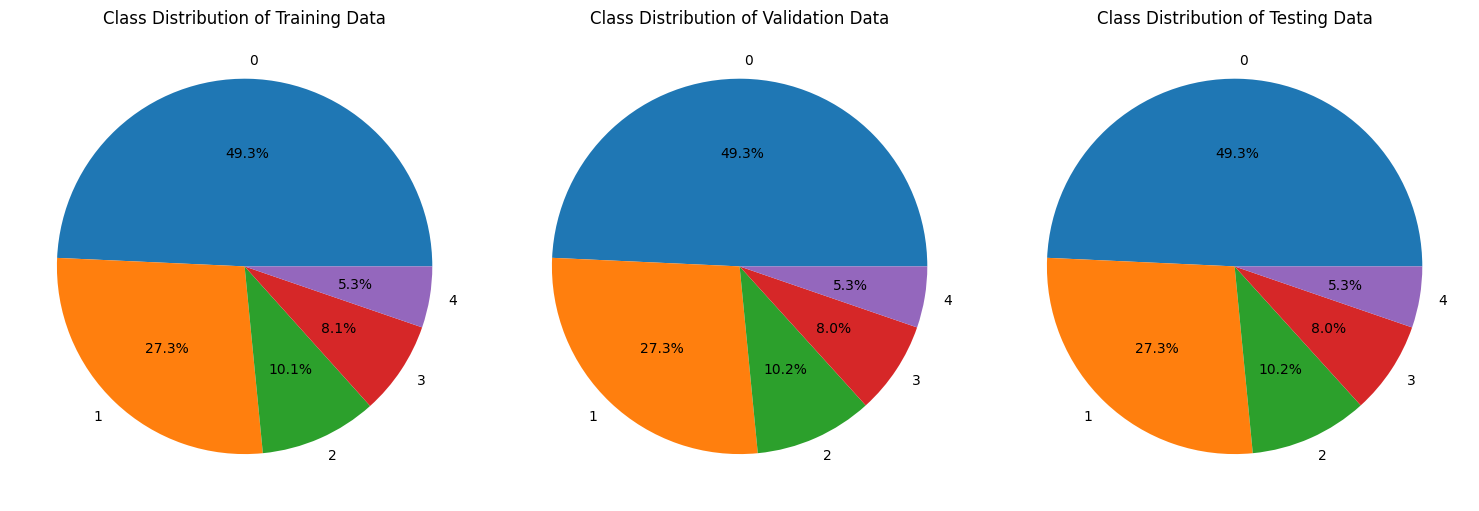

In [ ]:
# Create three pie charts
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.pie(train_counts, labels=categories, autopct='%1.1f%%')
plt.title('Class Distribution of Training Data')

plt.subplot(1, 3, 2)
plt.pie(val_counts, labels=categories, autopct='%1.1f%%')
plt.title('Class Distribution of Validation Data')

plt.subplot(1, 3, 3)
plt.pie(test_counts, labels=categories, autopct='%1.1f%%')
plt.title('Class Distribution of Testing Data')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
os.listdir()

['.config',
 'train.csv',
 'aptos2019-blindness-detection.zip',
 'kaggle.json',
 'sample_submission.csv',
 'test.csv',
 'dataset',
 'test_images',
 'diabetic-retinopathy-224x224-gaussian-filtered.zip',
 'train_images',
 'sample_data']

##AUGMENTATION (ROTATION) 1263

In [ ]:
import os
import cv2
import random
import keras.preprocessing.image
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Define the path to the main dataset folder containing train, val, and test folders
main_folder = "/content/dataset/train"

# Define the target number of images per class
target_count = 1263

# Function to perform data augmentation
def augment_images(src_folder, target_count):
    if not os.path.exists(src_folder):
        print(f"Folder {src_folder} does not exist.")
        return

    image_files = [f for f in os.listdir(src_folder) if f.endswith((".png"))]
    total_images = len(image_files)

    rotations_needed = int(max(0, np.ceil(target_count / total_images)) - 1)

    datagen = keras.preprocessing.image.ImageDataGenerator(
		rotation_range = 90)

    while total_images < target_count:
        # Randomly select an image from the class folder
        random_image = random.choice(image_files)
        src_path = os.path.join(src_folder, random_image)

        # Read the image using OpenCV
        img = load_img(src_path)

        x = img_to_array(img)
        # Reshaping the input image
        x = x.reshape((1, ) + x.shape)

        # Generating and saving 5 augmented samples using the above defined parameters.
        i = 0
        total_images += rotations_needed
        for batch in datagen.flow(x, batch_size = 1, save_to_dir =src_folder, save_prefix ='image', save_format ='png'):
            i += 1
            #if i > 5:
            if i >= rotations_needed:  # Number of rotations per original image
                break





# Function to process all classes in the main dataset folder
def process_classes(main_folder):
    class_folders = [os.path.join(main_folder, folder) for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

    for class_folder in class_folders:
        class_images = [f for f in os.listdir(class_folder) if f.endswith((".png"))]
        images_count = len(class_images)
        if images_count < target_count:
            print(f"Augmenting images in class folder: {class_folder}")
            augment_images(class_folder, target_count)

# Process all classes in the main dataset folder
process_classes(main_folder)

Augmenting images in class folder: /content/dataset/train/3
Augmenting images in class folder: /content/dataset/train/1
Augmenting images in class folder: /content/dataset/train/2
Augmenting images in class folder: /content/dataset/train/4


In [ ]:
len(os.listdir('/content/dataset/train/1'))

1214

In [ ]:
import os
import glob
import random

def delete_images_randomly(directory, num_images_to_delete):
    # Get a list of all image files in the directory
    image_files = glob.glob(os.path.join(directory, "*.png"))

    # Check if the number of images to delete is within the available range
    num_images_to_delete = min(num_images_to_delete, len(image_files))

    # Shuffle the list of images randomly
    random.shuffle(image_files)

    # Delete the specified number of images
    for i in range(num_images_to_delete):
        try:
            os.remove(image_files[i])
            print(f"Deleted: {image_files[i]}")
        except OSError as e:
            print(f"Error deleting {image_files[i]}: {e}")

# Example usage
directory_to_clean = '/content/dataset/train/0'

num_images_to_delete = 0 # Change this to the desired number of images to delete

delete_images_randomly(directory_to_clean, num_images_to_delete)


##AUGMENTATION (ROTATION + ZOOM) 1263

In [ ]:
import os
import cv2
import random
import keras.preprocessing.image
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Define the path to the main dataset folder containing train, val, and test folders
main_folder = "/content/dataset/train"

# Define the target number of images per class
target_count = 1263

# Function to perform data augmentation
def augment_images(src_folder, target_count):
    if not os.path.exists(src_folder):
        print(f"Folder {src_folder} does not exist.")
        return

    image_files = [f for f in os.listdir(src_folder) if f.endswith((".png"))]
    total_images = len(image_files)

    rotations_needed = int(max(0, np.ceil(target_count / total_images)) - 1)

    datagen = keras.preprocessing.image.ImageDataGenerator(
		rotation_range = 359,
    zoom_range=0.2)

    while total_images < target_count:
        # Randomly select an image from the class folder
        random_image = random.choice(image_files)
        src_path = os.path.join(src_folder, random_image)

        # Read the image using OpenCV
        img = load_img(src_path)

        x = img_to_array(img)
        # Reshaping the input image
        x = x.reshape((1, ) + x.shape)

        # Generating and saving 5 augmented samples using the above defined parameters.
        i = 0
        total_images += rotations_needed
        for batch in datagen.flow(x, batch_size = 1, save_to_dir =src_folder, save_prefix ='image', save_format ='png'):
            i += 1
            #if i > 5:
            if i >= rotations_needed:  # Number of rotations per original image
                break





# Function to process all classes in the main dataset folder
def process_classes(main_folder):
    class_folders = [os.path.join(main_folder, folder) for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

    for class_folder in class_folders:
        class_images = [f for f in os.listdir(class_folder) if f.endswith((".png"))]
        images_count = len(class_images)
        if images_count < target_count:
            print(f"Augmenting images in class folder: {class_folder}")
            augment_images(class_folder, target_count)

# Process all classes in the main dataset folder
process_classes(main_folder)

Augmenting images in class folder: /content/dataset/train/3
Augmenting images in class folder: /content/dataset/train/1
Augmenting images in class folder: /content/dataset/train/2
Augmenting images in class folder: /content/dataset/train/4


In [ ]:
len(os.listdir('/content/dataset/train/1'))

1214

In [ ]:
import os
import glob
import random

def delete_images_randomly(directory, num_images_to_delete):
    # Get a list of all image files in the directory
    image_files = glob.glob(os.path.join(directory, "*.png"))

    # Check if the number of images to delete is within the available range
    num_images_to_delete = min(num_images_to_delete, len(image_files))

    # Shuffle the list of images randomly
    random.shuffle(image_files)

    # Delete the specified number of images
    for i in range(num_images_to_delete):
        try:
            os.remove(image_files[i])
            print(f"Deleted: {image_files[i]}")
        except OSError as e:
            print(f"Error deleting {image_files[i]}: {e}")

# Example usage
directory_to_clean = '/content/dataset/train/0'

num_images_to_delete = 0 # Change this to the desired number of images to delete

delete_images_randomly(directory_to_clean, num_images_to_delete)


##AUGMENTATION (ROTATION) 900

In [20]:
import os
import cv2
import random
import keras.preprocessing.image
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Define the path to the main dataset folder containing train, val, and test folders
main_folder = "/content/dataset/train"

# Define the target number of images per class
target_count = 900

# Function to perform data augmentation
def augment_images(src_folder, target_count):
    if not os.path.exists(src_folder):
        print(f"Folder {src_folder} does not exist.")
        return

    image_files = [f for f in os.listdir(src_folder) if f.endswith((".png"))]
    total_images = len(image_files)

    rotations_needed = int(max(0, np.ceil(target_count / total_images)) - 1)

    datagen = keras.preprocessing.image.ImageDataGenerator(
		rotation_range = 180)

    while total_images < target_count:
        # Randomly select an image from the class folder
        random_image = random.choice(image_files)
        src_path = os.path.join(src_folder, random_image)

        # Read the image using OpenCV
        img = load_img(src_path)

        x = img_to_array(img)
        # Reshaping the input image
        x = x.reshape((1, ) + x.shape)

        # Generating and saving 5 augmented samples using the above defined parameters.
        i = 0
        total_images += rotations_needed
        for batch in datagen.flow(x, batch_size = 1, save_to_dir =src_folder, save_prefix ='image', save_format ='png'):
            i += 1
            #if i > 5:
            if i >= rotations_needed:  # Number of rotations per original image
                break





# Function to process all classes in the main dataset folder
def process_classes(main_folder):
    class_folders = [os.path.join(main_folder, folder) for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

    for class_folder in class_folders:
        class_images = [f for f in os.listdir(class_folder) if f.endswith((".png"))]
        images_count = len(class_images)
        if images_count < target_count:
            print(f"Augmenting images in class folder: {class_folder}")
            augment_images(class_folder, target_count)

# Process all classes in the main dataset folder
process_classes(main_folder)

Augmenting images in class folder: /content/dataset/train/1
Augmenting images in class folder: /content/dataset/train/2
Augmenting images in class folder: /content/dataset/train/3
Augmenting images in class folder: /content/dataset/train/4


In [26]:
len(os.listdir('/content/dataset/train/4'))

881

In [21]:
import os
import glob
import random

def delete_images_randomly(directory, num_images_to_delete):
    # Get a list of all image files in the directory
    image_files = glob.glob(os.path.join(directory, "*.png"))

    # Check if the number of images to delete is within the available range
    num_images_to_delete = min(num_images_to_delete, len(image_files))

    # Shuffle the list of images randomly
    random.shuffle(image_files)

    # Delete the specified number of images
    for i in range(num_images_to_delete):
        try:
            os.remove(image_files[i])
            print(f"Deleted: {image_files[i]}")
        except OSError as e:
            print(f"Error deleting {image_files[i]}: {e}")

# Example usage
directory_to_clean = '/content/dataset/train/0'

num_images_to_delete = 363 # Change this to the desired number of images to delete

delete_images_randomly(directory_to_clean, num_images_to_delete)


Deleted: /content/dataset/train/0/5e97cb2b0888.png
Deleted: /content/dataset/train/0/dfea19863428.png
Deleted: /content/dataset/train/0/09c8323c612e.png
Deleted: /content/dataset/train/0/9e2a8135f471.png
Deleted: /content/dataset/train/0/201f882365d3.png
Deleted: /content/dataset/train/0/e7b5dd5bab1f.png
Deleted: /content/dataset/train/0/c3b15bf9b4bc.png
Deleted: /content/dataset/train/0/d2c5fb82fe5f.png
Deleted: /content/dataset/train/0/c096131ad065.png
Deleted: /content/dataset/train/0/8b8fe3fc8950.png
Deleted: /content/dataset/train/0/3cab32dd6ef9.png
Deleted: /content/dataset/train/0/35beb47fe159.png
Deleted: /content/dataset/train/0/db52626d450c.png
Deleted: /content/dataset/train/0/ff4832d55461.png
Deleted: /content/dataset/train/0/59bd19c1c5bb.png
Deleted: /content/dataset/train/0/b549af91bd30.png
Deleted: /content/dataset/train/0/cb02bb47fdc5.png
Deleted: /content/dataset/train/0/7526cf435753.png
Deleted: /content/dataset/train/0/ef7eb85b75fc.png
Deleted: /content/dataset/train

##AUGMENTATION (ROTATION + ZOOM) 900

In [ ]:
import os
import cv2
import random
import keras.preprocessing.image
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Define the path to the main dataset folder containing train, val, and test folders
main_folder = "/content/dataset/train"

# Define the target number of images per class
target_count = 900

# Function to perform data augmentation
def augment_images(src_folder, target_count):
    if not os.path.exists(src_folder):
        print(f"Folder {src_folder} does not exist.")
        return

    image_files = [f for f in os.listdir(src_folder) if f.endswith((".png"))]
    total_images = len(image_files)

    rotations_needed = int(max(0, np.ceil(target_count / total_images)) - 1)

    datagen = keras.preprocessing.image.ImageDataGenerator(
		rotation_range = 359,
    zoom_range=0.2)

    while total_images < target_count:
        # Randomly select an image from the class folder
        random_image = random.choice(image_files)
        src_path = os.path.join(src_folder, random_image)

        # Read the image using OpenCV
        img = load_img(src_path)

        x = img_to_array(img)
        # Reshaping the input image
        x = x.reshape((1, ) + x.shape)

        # Generating and saving 5 augmented samples using the above defined parameters.
        i = 0
        total_images += rotations_needed
        for batch in datagen.flow(x, batch_size = 1, save_to_dir =src_folder, save_prefix ='image', save_format ='png'):
            i += 1
            #if i > 5:
            if i >= rotations_needed:  # Number of rotations per original image
                break





# Function to process all classes in the main dataset folder
def process_classes(main_folder):
    class_folders = [os.path.join(main_folder, folder) for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

    for class_folder in class_folders:
        class_images = [f for f in os.listdir(class_folder) if f.endswith((".png"))]
        images_count = len(class_images)
        if images_count < target_count:
            print(f"Augmenting images in class folder: {class_folder}")
            augment_images(class_folder, target_count)

# Process all classes in the main dataset folder
process_classes(main_folder)

Augmenting images in class folder: /content/dataset/train/3
Augmenting images in class folder: /content/dataset/train/1
Augmenting images in class folder: /content/dataset/train/2
Augmenting images in class folder: /content/dataset/train/4


In [ ]:
len(os.listdir('/content/dataset/train/1'))

1214

In [ ]:
import os
import glob
import random

def delete_images_randomly(directory, num_images_to_delete):
    # Get a list of all image files in the directory
    image_files = glob.glob(os.path.join(directory, "*.png"))

    # Check if the number of images to delete is within the available range
    num_images_to_delete = min(num_images_to_delete, len(image_files))

    # Shuffle the list of images randomly
    random.shuffle(image_files)

    # Delete the specified number of images
    for i in range(num_images_to_delete):
        try:
            os.remove(image_files[i])
            print(f"Deleted: {image_files[i]}")
        except OSError as e:
            print(f"Error deleting {image_files[i]}: {e}")

# Example usage
directory_to_clean = '/content/dataset/train/0'

num_images_to_delete = 363 # Change this to the desired number of images to delete

delete_images_randomly(directory_to_clean, num_images_to_delete)


#CHECKING BALANCE AFTER AUGMENTATION

#YOLOV8 DEPENDENCIES

In [27]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.7/645.7 kB 10.5 MB/s eta 0:00:00


In [28]:
!pip show ultralytics

Name: ultralytics
Version: 8.0.216
Summary: Ultralytics YOLOv8 for SOTA object detection, multi-object tracking, instance segmentation, pose estimation and image classification.
Home-page: https://github.com/ultralytics/ultralytics
Author: Ultralytics
Author-email: hello@ultralytics.com
License: AGPL-3.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, opencv-python, pandas, pillow, psutil, py-cpuinfo, pyyaml, requests, scipy, seaborn, thop, torch, torchvision, tqdm
Required-by: 


In [29]:
!pip uninstall -y albumentations

Found existing installation: albumentations 1.3.1
Uninstalling albumentations-1.3.1:
  Successfully uninstalled albumentations-1.3.1


In [30]:
import os
from ultralytics import YOLO

#YOLOV8X_pretrained 10epochs 640imgsz no_circle_crop

In [ ]:
model = YOLO("yolov8m-cls.pt")

results = model.train(data='/content/dataset', epochs=10, imgsz=640)

In [ ]:
results_path = '/content/runs/classify/train2/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
#model = YOLO('path/to/best.pt')

metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

#YOLOV8x 10epochs 244imgsz no_circle_crop

In [ ]:
model = YOLO('yolov8x-cls.yaml')  # build a new model from YAML
model = YOLO('yolov8x-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8x-cls.yaml').load('yolov8x-cls.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   7375360  ultralytics.nn.modules.conv.Conv             [640

100%|██████████| 110M/110M [00:00<00:00, 330MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   7375360  ultralytics.nn.modules.conv.Conv             [640

In [ ]:
results = model.train(data='/content/dataset', epochs=10, imgsz=244)

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8x-cls.yaml, data=/content/dataset, epochs=10, patience=50, batch=16, imgsz=244, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimi

100%|██████████| 6.23M/6.23M [00:00<00:00, 208MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅
WARNING ⚠️ imgsz=[244] must be multiple of max stride 32, updating to [256]


train: Scanning /content/dataset/train... 6159 images, 0 corrupt: 100%|██████████| 6159/6159 [00:32<00:00, 192.39it/s]

train: New cache created: /content/dataset/train.cache



val: Scanning /content/dataset/val... 550 images, 0 corrupt: 100%|██████████| 550/550 [00:02<00:00, 223.27it/s]

val: New cache created: /content/dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/10      2.53G     0.4105         16        256:   3%|▎         | 10/385 [00:05<02:20,  2.67it/s]

       1/10      2.53G     0.4107         16        256:   4%|▍         | 16/385 [00:07<02:14,  2.74it/s]
100%|██████████| 755k/755k [00:00<00:00, 48.5MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  3.83it/s]

                   all      0.775          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:05<00:00,  3.41it/s]

                   all      0.753          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  3.93it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]

                   all      0.804          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  3.92it/s]

                   all      0.824          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:06<00:00,  2.86it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]

                   all      0.825          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:04<00:00,  3.91it/s]

                   all      0.831          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10      2.63G   0.002393         15        256: 100%|██████████| 385/385 [01:42<00:00,  3.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:05<00:00,  3.29it/s]

                   all      0.831          1



10 epochs completed in 0.325 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 112.5MB
Optimizer stripped from runs/classify/train/weights/best.pt, 112.5MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-cls summary (fused): 133 layers, 56129605 parameters, 0 gradients, 153.8 GFLOPs
train: /content/dataset/train... found 6159 images in 5 classes ✅ 
val: /content/dataset/val... found 550 images in 5 classes ✅ 
test: /content/dataset/test... found 550 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]


                   all      0.831          1
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


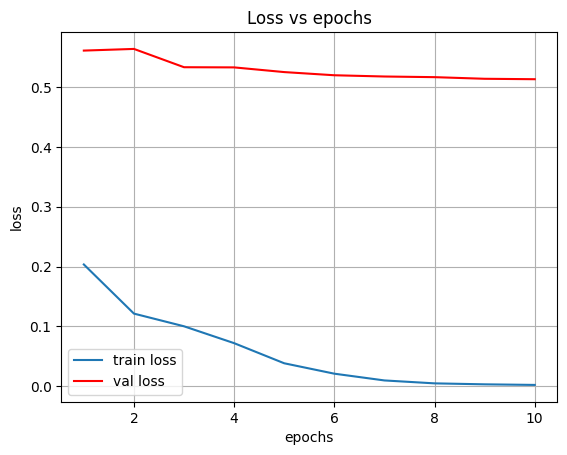

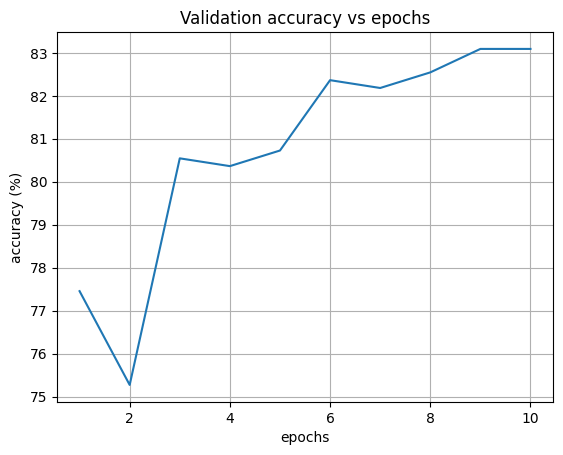

In [ ]:
results_path = '/content/runs/classify/train/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
#model = YOLO('path/to/best.pt')

metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-cls summary (fused): 133 layers, 56129605 parameters, 0 gradients, 153.8 GFLOPs
train: /content/dataset/train... found 6159 images in 5 classes ✅ 
val: /content/dataset/val... found 550 images in 5 classes ✅ 
test: /content/dataset/test... found 550 images in 5 classes ✅ 


val: Scanning /content/dataset/val... 550 images, 0 corrupt: 100%|██████████| 550/550 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:07<00:00,  4.89it/s]


                   all      0.831          1
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


1.0

#YOLOV8x 20epochs 640imgsz no_circle_crop

In [ ]:
model = YOLO('yolov8x-cls.yaml')  # build a new model from YAML
model = YOLO('yolov8x-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8x-cls.yaml').load('yolov8x-cls.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   7375360  ultralytics.nn.modules.conv.Conv             [640

In [ ]:
results = model.train(data='/content/dataset', epochs=20, imgsz=640)

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8x-cls.yaml, data=/content/dataset, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

train: Scanning /content/dataset/train... 6159 images, 0 corrupt: 100%|██████████| 6159/6159 [00:00<?, ?it/s]
val: Scanning /content/dataset/val... 550 images, 0 corrupt: 100%|██████████| 550/550 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train3
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]

                   all      0.802          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.74it/s]

                   all      0.802          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]

                   all      0.813          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]

                   all      0.824          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]

                   all      0.791          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]

                   all      0.795          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]

                   all      0.845          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]

                   all      0.855          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]

                   all      0.844          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20      9.94G   0.006702         15        640: 100%|██████████| 385/385 [04:36<00:00,  1.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]

                   all      0.851          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20      9.96G   0.004824         15        640: 100%|██████████| 385/385 [04:36<00:00,  1.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]

                   all      0.853          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20      9.98G   0.004341         15        640: 100%|██████████| 385/385 [04:35<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]

                   all      0.855          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20      9.96G   0.002908         15        640: 100%|██████████| 385/385 [04:35<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]

                   all      0.844          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20      9.94G   0.002336         15        640: 100%|██████████| 385/385 [04:35<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]

                   all      0.851          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20      9.96G    0.00193         15        640: 100%|██████████| 385/385 [04:34<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]

                   all      0.855          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20      9.99G   0.001905         15        640: 100%|██████████| 385/385 [04:32<00:00,  1.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]

                   all      0.845          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20      9.98G   0.001756         15        640: 100%|██████████| 385/385 [04:33<00:00,  1.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]

                   all      0.844          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20      9.95G   0.001697         15        640: 100%|██████████| 385/385 [04:33<00:00,  1.41it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20      9.96G   0.001629         15        640: 100%|██████████| 385/385 [04:34<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]

                   all      0.847          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20      9.97G   0.001525         15        640: 100%|██████████| 385/385 [04:34<00:00,  1.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]

                   all      0.842          1



20 epochs completed in 1.702 hours.
Optimizer stripped from runs/classify/train3/weights/last.pt, 112.5MB
Optimizer stripped from runs/classify/train3/weights/best.pt, 112.5MB

Validating runs/classify/train3/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-cls summary (fused): 133 layers, 56129605 parameters, 0 gradients, 153.8 GFLOPs
train: /content/dataset/train... found 6159 images in 5 classes ✅ 
val: /content/dataset/val... found 550 images in 5 classes ✅ 
test: /content/dataset/test... found 550 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]


                   all      0.855          1
Speed: 0.8ms preprocess, 13.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train3
Results saved to runs/classify/train3


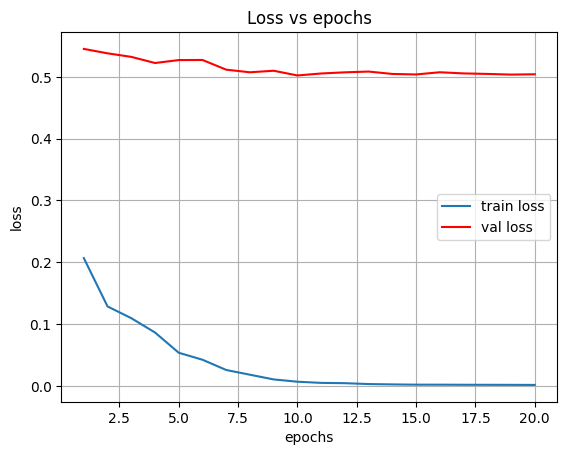

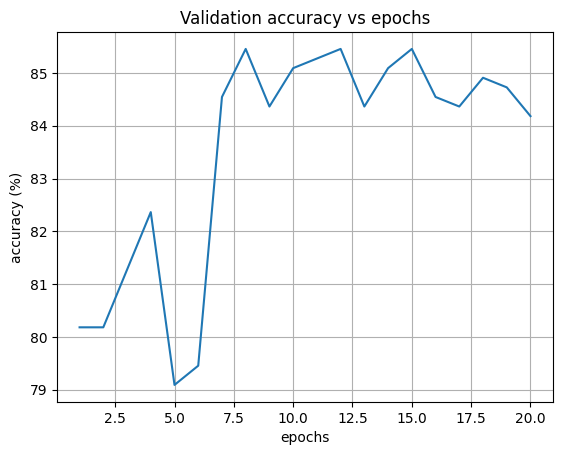

In [ ]:
results_path = '/content/runs/classify/train3/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
#model = YOLO('path/to/best.pt')

metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-cls summary (fused): 133 layers, 56129605 parameters, 0 gradients, 153.8 GFLOPs
train: /content/dataset/train... found 6159 images in 5 classes ✅ 
val: /content/dataset/val... found 550 images in 5 classes ✅ 
test: /content/dataset/test... found 550 images in 5 classes ✅ 


val: Scanning /content/dataset/val... 550 images, 0 corrupt: 100%|██████████| 550/550 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


                   all      0.855          1
Speed: 1.0ms preprocess, 34.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train32


1.0

#VGG19 10epochs 240imgsz no_circle_crop

In [ ]:
IMAGE_SIZE=240
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [ ]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(
    #'/content/ISIC - 2019/train',
    '/content/dataset/train',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6137 files belonging to 5 classes.


In [ ]:
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    #'/content/ISIC - 2019/val',
    '/content/dataset/val',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 550 files belonging to 5 classes.


In [ ]:
class_names=train_data.class_names
class_names

['0', '1', '2', '3', '4']

In [ ]:
len(train_data)

192

In [ ]:
len(val_data)

18

In [ ]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 240, 240, 3)
[0 3 3 1 3 2 0 4 1 4 2 2 2 2 4 4 2 2 0 1 2 0 2 0 1 2 2 3 4 3 4 2]


In [ ]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch[0].numpy())

[[[        128         128         128]
  [        128         128         128]
  [        128         128         128]
  ...
  [        128         128         128]
  [        128         128         128]
  [        128         128         128]]

 [[        128         128         128]
  [        128         128         128]
  [        128         128         128]
  ...
  [        128         128         128]
  [        128         128         128]
  [        128         128         128]]

 [[        128         128         128]
  [        128         128         128]
  [        128         128         128]
  ...
  [        128         128         128]
  [        128         128         128]
  [        128         128         128]]

 ...

 [[        128         128         128]
  [        128         128         128]
  [        128         128         128]
  ...
  [        128         128         128]
  [        128         128         128]
  [        128         128         128]]

 [

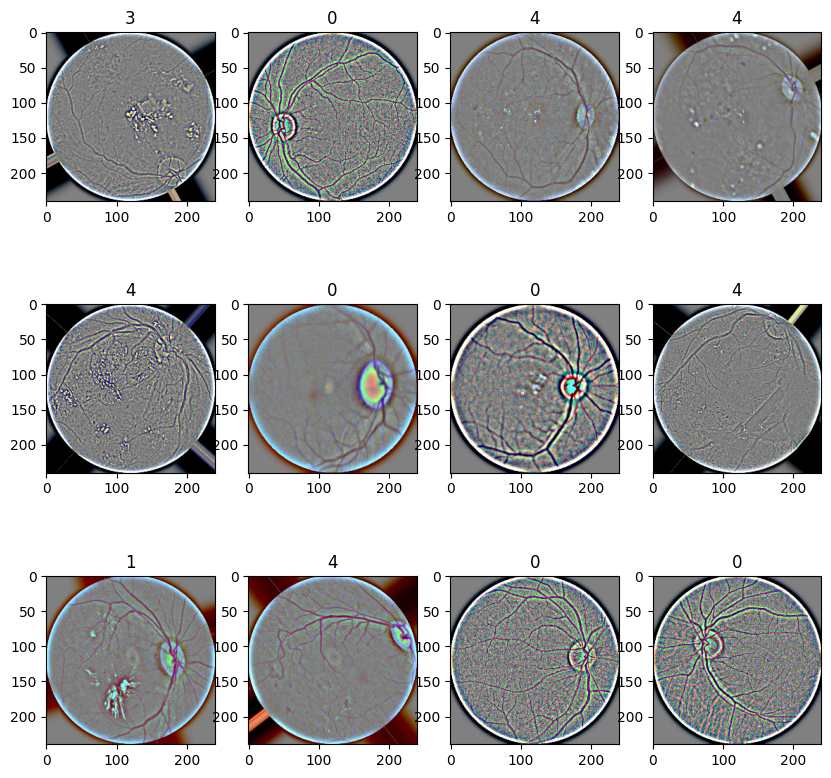

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_data.take(3):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i].numpy()])

In [ ]:
from tensorflow.keras import applications, Model, optimizers
from tensorflow.keras.layers import Flatten, Dense

In [ ]:
base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0   

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/10
193/193 [==============================] - 95s 446ms/step - loss: 21.5047 - accuracy: 0.5207 - val_loss: 0.8260 - val_accuracy: 0.7055
Epoch 2/10
193/193 [==============================] - 83s 419ms/step - loss: 0.9800 - accuracy: 0.6121 - val_loss: 0.7221 - val_accuracy: 0.7400
Epoch 3/10
193/193 [==============================] - 85s 423ms/step - loss: 0.8748 - accuracy: 0.6598 - val_loss: 0.8856 - val_accuracy: 0.7236
Epoch 4/10
193/193 [==============================] - 84s 422ms/step - loss: 0.7514 - accuracy: 0.7139 - val_loss: 0.7572 - val_accuracy: 0.7436
Epoch 5/10
193/193 [==============================] - 84s 417ms/step - loss: 0.6595 - accuracy: 0.7633 - val_loss: 0.7264 - val_accuracy: 0.7545
Epoch 6/10
193/193 [==============================] - 84s 422ms/step - loss: 0.6402 - accuracy: 0.7693 - val_loss: 0.7421 - val_accuracy: 0.7491
Epoch 7/10
193/193 [==============================] - 85s 421ms/step - loss: 0.5478 - accuracy: 0.8048 - val_loss: 1.0418 - val_a

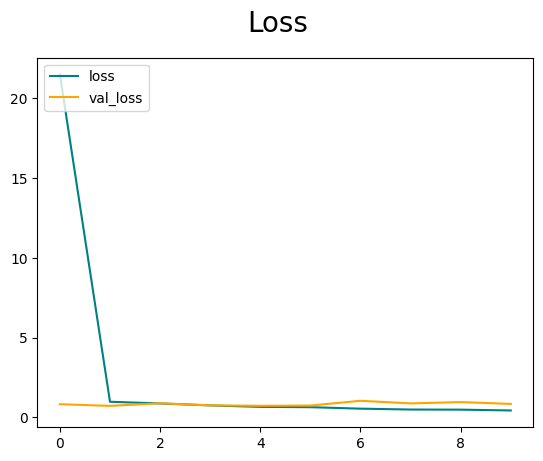

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

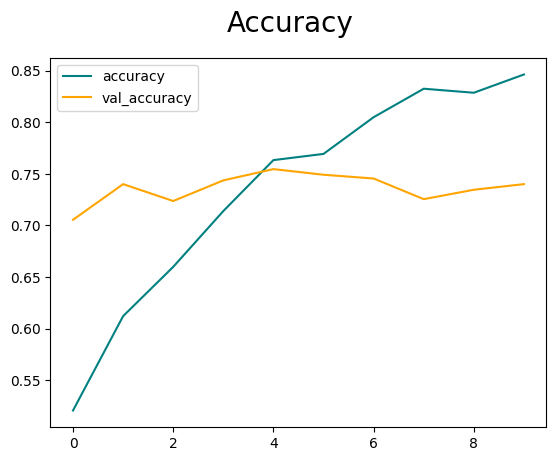

In [ ]:
fig = plt.figure()
plt.plot(hist.history['train_accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for X, y in test_data:
    yhat=np.argmax(model.predict(X), axis=1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

NameError: ignored

In [ ]:
print(pre.result(), re.result(), acc.result())

#YOLOV8x 20epochs 640imgsz circle_crop

In [ ]:
model = YOLO('yolov8x-cls.yaml')  # build a new model from YAML
model = YOLO('yolov8x-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8x-cls.yaml').load('yolov8x-cls.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   7375360  ultralytics.nn.modules.conv.Conv             [640

100%|██████████| 110M/110M [00:00<00:00, 220MB/s] 



                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   7375360  ultralytics.nn.modules.conv.Conv             [640

In [ ]:
results = model.train(data='/content/dataset', epochs=20, imgsz=640)

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8x-cls.yaml, data=/content/dataset, epochs=20, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimi

100%|██████████| 6.23M/6.23M [00:00<00:00, 224MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/dataset/train... 6137 images, 0 corrupt: 100%|██████████| 6137/6137 [00:31<00:00, 194.70it/s]

train: New cache created: /content/dataset/train.cache



val: Scanning /content/dataset/val... 550 images, 0 corrupt: 100%|██████████| 550/550 [00:03<00:00, 153.83it/s]

val: New cache created: /content/dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/20       9.5G     0.4207         16        640:   1%|          | 4/384 [00:04<06:16,  1.01it/s]

       1/20       9.5G     0.4125         16        640:   2%|▏         | 7/384 [00:06<05:00,  1.25it/s]
100%|██████████| 755k/755k [00:00<00:00, 83.2MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]

                   all      0.765          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.80it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.59it/s]

                   all      0.793          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]

                   all      0.809          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]

                   all      0.773          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]

                   all      0.787          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]

                   all      0.782          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]

                   all        0.8          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]

                   all      0.787          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20      9.93G   0.007603          9        640: 100%|██████████| 384/384 [04:59<00:00,  1.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20      9.94G   0.004963          9        640: 100%|██████████| 384/384 [05:00<00:00,  1.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.58it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20      9.94G   0.003788          9        640: 100%|██████████| 384/384 [04:58<00:00,  1.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]

                   all      0.809          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20      9.91G   0.003157          9        640: 100%|██████████| 384/384 [04:57<00:00,  1.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]

                   all      0.811          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20      9.94G   0.002413          9        640: 100%|██████████| 384/384 [04:57<00:00,  1.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.56it/s]

                   all      0.796          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20      9.94G   0.001598          9        640: 100%|██████████| 384/384 [04:57<00:00,  1.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20      9.93G    0.00175          9        640: 100%|██████████| 384/384 [04:56<00:00,  1.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20      9.92G   0.001576          9        640: 100%|██████████| 384/384 [04:56<00:00,  1.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]

                   all      0.804          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20      9.94G   0.001253          9        640: 100%|██████████| 384/384 [04:55<00:00,  1.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.55it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20      9.93G   0.001096          9        640: 100%|██████████| 384/384 [04:57<00:00,  1.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20      9.94G   0.001086          9        640: 100%|██████████| 384/384 [04:58<00:00,  1.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]

                   all      0.807          1



20 epochs completed in 1.893 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 112.5MB
Optimizer stripped from runs/classify/train/weights/best.pt, 112.5MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-cls summary (fused): 133 layers, 56129605 parameters, 0 gradients, 153.8 GFLOPs
train: /content/dataset/train... found 6137 images in 5 classes ✅ 
val: /content/dataset/val... found 550 images in 5 classes ✅ 
test: /content/dataset/test... found 550 images in 5 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


                   all      0.811          1
Speed: 0.8ms preprocess, 14.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


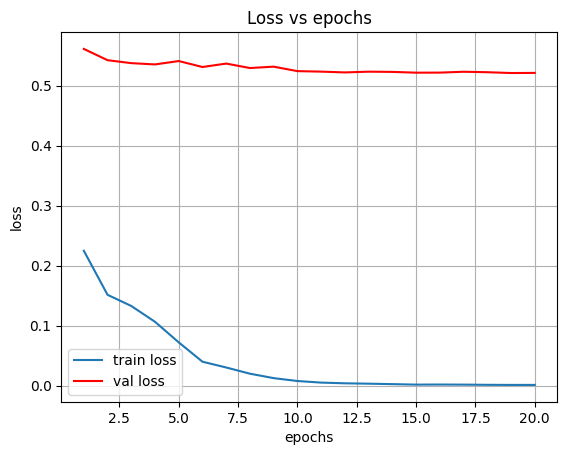

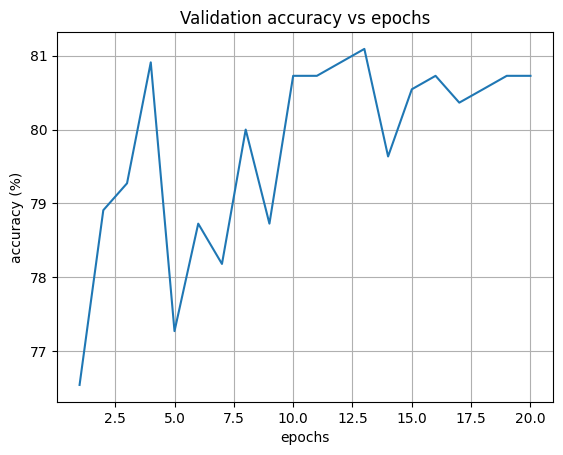

In [ ]:
results_path = '/content/runs/classify/train/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
#model = YOLO('path/to/best.pt')

metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x-cls summary (fused): 133 layers, 56129605 parameters, 0 gradients, 153.8 GFLOPs
train: /content/dataset/train... found 6137 images in 5 classes ✅ 
val: /content/dataset/val... found 550 images in 5 classes ✅ 
test: /content/dataset/test... found 550 images in 5 classes ✅ 


val: Scanning /content/dataset/val... 550 images, 0 corrupt: 100%|██████████| 550/550 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:24<00:00,  1.44it/s]


                   all      0.809          1
Speed: 1.8ms preprocess, 36.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


1.0

#YOLOV8x 20epocs 1024imgsz 900imgs


In [31]:
model = YOLO('yolov8x-cls.yaml')  # build a new model from YAML
model = YOLO('yolov8x-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8x-cls.yaml').load('yolov8x-cls.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   7375360  ultralytics.nn.modules.conv.Conv             [640

100%|██████████| 110M/110M [00:00<00:00, 170MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   7375360  ultralytics.nn.modules.conv.Conv             [640

In [32]:
results = model.train(data='/content/dataset', epochs=20, imgsz=1024)

Ultralytics YOLOv8.0.216 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8x-cls.yaml, data=/content/dataset, epochs=20, patience=50, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optim

100%|██████████| 6.23M/6.23M [00:00<00:00, 78.1MB/s]


WARNING ⚠️ NMS time limit 0.550s exceeded
AMP: checks passed ✅


train: Scanning /content/dataset/train... 4442 images, 1 corrupt: 100%|██████████| 4443/4443 [00:39<00:00, 113.30it/s]

train: WARNING ⚠️ /content/dataset/train/1/image_0_5862.png: ignoring corrupt image/label: truncated PNG file


train: New cache created: /content/dataset/train.cache


val: Scanning /content/dataset/val... 550 images, 0 corrupt: 100%|██████████| 550/550 [00:05<00:00, 91.71it/s] 

val: New cache created: /content/dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


  0%|          | 0/278 [00:01<?, ?it/s]


OutOfMemoryError: ignored

In [ ]:
results_path = '/content/runs/classify/train/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [ ]:
#model = YOLO('path/to/best.pt')

metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:

# Define the data paths
train_data_dir = 'path_to_train_data_directory'
validation_data_dir = 'path_to_validation_data_directory'

In [ ]:

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Create ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create ImageDataGenerator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

In [ ]:

# Load pre-trained ResNet-152V2 model
resnet152v2_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in resnet152v2_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
num_classes = 5  # Change this based on the number of classes in your task

# Flatten the output from the pre-trained ResNet model
x = layers.Flatten()(resnet152v2_model.output)
# Add dense layers
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# Output layer with softmax activation for classification
output_layer = layers.Dense(num_classes, activation='softmax')(x)


In [ ]:

# Create the modified model
resnet152v2_custom_model = models.Model(inputs=resnet152v2_model.input, outputs=output_layer)


In [ ]:

# Compile the model
resnet152v2_custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:

# Train the model
history = resnet152v2_custom_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Adjust the number of epochs based on your specific requirements
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)



In [ ]:
# Evaluate the model
evaluation = resnet152v2_custom_model.evaluate(test_generator)
print("Validation Accuracy: {:.2f}%".format(evaluation[1] * 100))

In [ ]:
import os

def get_folder_size(folder_path='.'):
    total_size = 0
    with os.scandir(folder_path) as it:
        for entry in it:
            if entry.is_file():
                total_size += entry.stat().st_size
            elif entry.is_dir():
                total_size += get_folder_size(entry.path)
    return total_size

# Specify the path to the folder you want to check (replace 'path_to_your_folder' with the actual path)
folder_path = 'path_to_your_folder'

# Get the size of the folder
folder_size = get_folder_size(folder_path)

# Convert bytes to kilobytes
folder_size_kb = folder_size / 1024.0

print(f"Size of folder '{folder_path}': {folder_size_kb:.2f} KB")


In [34]:
import shutil
import os

# Specify the path to the folder you want to download (replace 'path_to_your_folder' with the actual path)
folder_path = '/content/dataset'

# Specify the name of the zip file
zip_filename = 'aptos_dataset_processed.zip'

# Create a zip file of the folder
shutil.make_archive(zip_filename, 'zip', folder_path)

# Move the zip file to the /content directory (where Colab stores downloaded files)
shutil.move(zip_filename + '.zip', '/content/' + zip_filename + '.zip')

# Provide a link to download the zip file
print(f"Folder '{folder_path}' has been zipped. Download it here:")
print(f"/content/{zip_filename}.zip")


Folder '/content/dataset' has been zipped. Download it here:
/content/aptos_dataset_processed.zip.zip
